In [1]:
# Restart the kernel
import os
current_dir ='../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
from src.codes.base_classes import Base_class_fem_heat_conduction
from src.codes.reductor.rom_class import FEM_solver_rom_ecsw
from src.codes.algorithms.ecsw import ecsw_red


### class for data (geometry, material property, mesh)

In [3]:
n_ref = np.array([400, 100], dtype=int)
w = np.array([ 0.4, 0.1])
L = np.sum(w)

# Create arrays of zeros and ones
zeros_array = np.zeros((1, n_ref[0]))
ones_array = np.ones((1, n_ref[1]))

# Concatenate along the second axis (axis=1)
mat_layout = np.concatenate((zeros_array, ones_array), axis=1)
src_layout = np.concatenate((zeros_array, ones_array), axis=1)

In [4]:
fdict = {}

tune = 0.01

cond_list = []
cond_list.append(lambda T,mu: 1.05*mu*tune + 2150/(T-73.15))
cond_list.append(lambda T,mu: mu*tune*7.51 + 2.09e-2*T - 1.45e-5*T**2 + 7.67e-9*T**3)
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append(lambda T,mu: -2150/(T-73.15)**2 )
dcond_list.append(lambda T,mu: 2.09e-2 - 2*1.45e-5*T + 3*7.67e-9*T**2)
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 35000.0 + 0.*T)
qext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["qext"] = qext_list

In [5]:
bc = {}
bc['x_min']={'type':'refl','value':np.nan}
bc['x_max']={'type':'dirichlet','value':273.15+300.}   

In [6]:
print(mat_layout.flatten().shape[0])

500


In [7]:
class probdata:
    
    def __init__(self, bc, cond_layout, qext_layout, fdict, nref, L, mu, pb_dim=1):
        
        self.dim_ = pb_dim

        # refine the mesh and update material and source layouts
        self.cell2mat_layout = cond_layout.flatten()
        self.cell2src_layout = qext_layout.flatten()
        
        ## change this mapping if needed.
        self.fdict = fdict
        
        # mesh data cells
        self.ncells = [None] * pb_dim
        self.npts = [None] * pb_dim
        self.deltas = [None] * pb_dim
        self.xi=[]

        for i in range(pb_dim):

            self.ncells[i] = self.cell2mat_layout.shape[i]
            self.npts[i] = self.ncells[i]+1
            self.xi.append(np.linspace(0,L,self.npts[i]))
            self.deltas[i] = L/self.ncells[i]
    
        self.n_verts = self.npts[0]

        # Create nodal connectivity for the continuous Finite Element Method (cFEM)
        self.connectivity()
                
        # Store parameter value
        self.mu = mu
        
        # Store the dirichlet nodes if any
        handle_boundary_conditions(self, bc)
        
        # Determining the global equation numbers based on dirichlet nodes and storing in class
        get_glob_node_equation_id(self, self.dir_nodes)

        # Get global node numbers and equation IDs for the current element
        self.glob_node_eqnId = []
        self.glob_node_nonzero_eqnId = []
        self.local_node_nonzero_eqnId = []
        self.Le = []
        self.global_indices = []
        self.local_indices = []

        for i in range(self.n_cells):
            get_element_global_nodes_and_nonzero_eqnId(self, i, self.node_eqnId)   
    
    
    def connectivity(self):
        """
        Define nodal connectivity for each cell in the mesh.
        """

        # Initialize the connectivity array
        self.n_cells = self.ncells[0]
        
        self.gn = np.zeros((self.n_cells,2**self.dim_),dtype=int)
        
        # Loop over all cells to define their nodal connectivity
        
        for iel in range(self.n_cells):
            # For each cell, define the left and right nodes
            self.gn[iel, 0] = iel
            self.gn[iel, 1] = iel + 1
  

### Simulate FOS

In [8]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []
# 

initial residual = 2102841.8888108297 

iter 0, NL residual=1155304.4844587285, delta=959.8233525897716
iter 1, NL residual=74048.66809417127, delta=903.8440651224566
iter 2, NL residual=494.54059550022566, delta=238.7003748791369
iter 3, NL residual=0.10778611616170244, delta=9.509058277674862
iter 4, NL residual=2.8333845504476297e-06, delta=0.017645550827083384
Convergence !!!
initial residual = 2083926.152467056 

iter 0, NL residual=1163473.4843131017, delta=965.1469806619228
iter 1, NL residual=75769.6924249477, delta=913.3853956679902
iter 2, NL residual=525.3742680618371, delta=242.33855486056592
iter 3, NL residual=0.11842858432042337, delta=9.580339085781057
iter 4, NL residual=2.9607737401496903e-06, delta=0.017698523885482913
Convergence !!!
initial residual = 2113876.0683534266 

iter 0, NL residual=1150646.3678681296, delta=956.7771474644215
iter 1, NL residual=73071.65702715478, delta=898.402370115903
iter 2, NL residual=477.5287147486767, delta=236.6289674105343
iter 3,

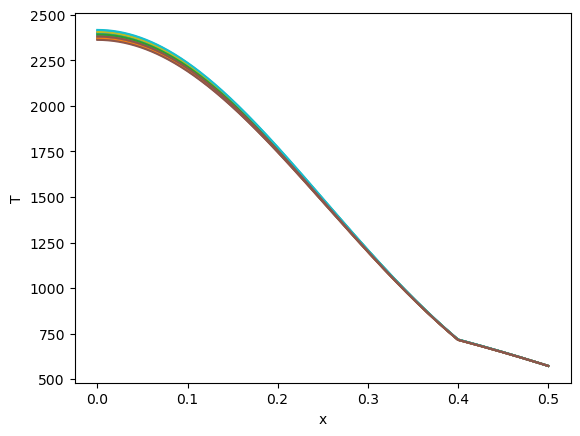

In [9]:
fig, ax = plt.subplots()

for i in range(N_snap):
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param, pb_dim=1)
        FOS = Base_class_fem_heat_conduction(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 273.15
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    plot1D(d.xi[0], NL_solution_p, ax=ax)

plt.show()


In [10]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 501)

### ECSW Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

In [11]:
n_sel = 6
U, S, Vt = np.linalg.svd(np.transpose(NLS), full_matrices=False)
V_sel = U[:, :n_sel]
P_sel = V_sel[mask,:]@np.transpose(V_sel[mask,:])

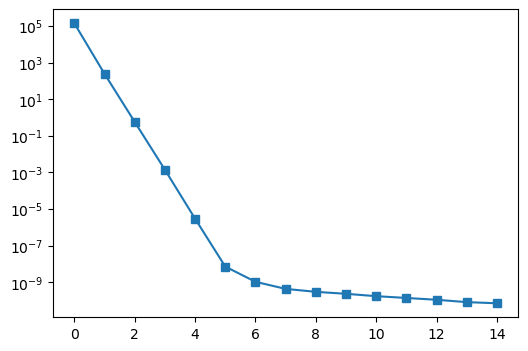

In [12]:
plt.figure(figsize = (6,4))
plt.semilogy(S,'s-')
plt.show()

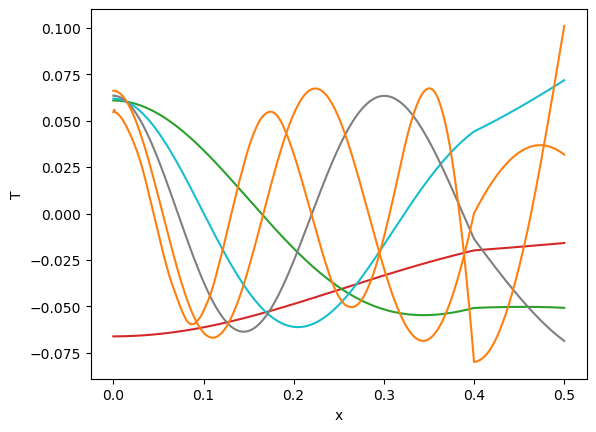

In [13]:
fig, ax = plt.subplots()

for i in range(n_sel):
    plot1D(d.xi[0],V_sel[:,i],ax=ax)

plt.show()


#### ECSW

In [35]:
tic_h_setup_b = time.time()
tol = 1e-30
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, P_sel, tol, n_sel, N_snap, mask,NL_solutions)
toc_h_setup_b = time.time()

In [36]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 0.12329909036005157


In [16]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

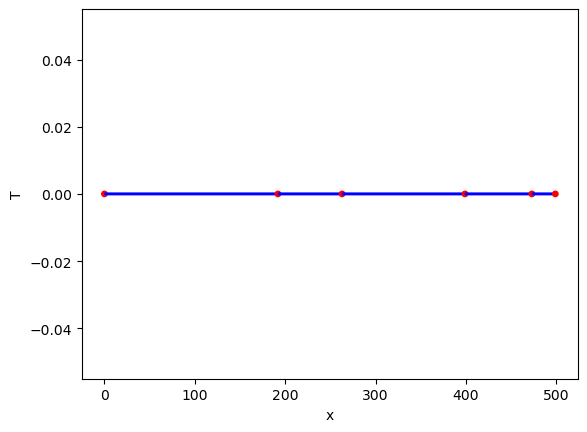

In [17]:
plot1D(np.arange(d.ncells[0]), np.zeros_like(xi), scattr=True, clr=colors, sz=sizes)

In [18]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 1.2%



### ROM Simulation

In [19]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [20]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
FOS_test = Base_class_fem_heat_conduction(d_test,quad_deg)
ROM = FEM_solver_rom_ecsw(d_test, quad_deg)

In [21]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [22]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

initial residual = 2107796.01023733 

iter 0, NL residual=1153203.4939097883, delta=958.4503541515244
iter 1, NL residual=73607.60368609658, delta=901.3897701996129
iter 2, NL residual=486.8167579890589, delta=237.76584793668064
iter 3, NL residual=0.10519031690202978, delta=9.488133067605345
iter 4, NL residual=2.7978466285480175e-06, delta=0.017616230494902674
Convergence !!!


In [23]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,np.ones_like(xi),V_sel)
toc_rom_woh = time.time()

initial residual = 228974.84065514663 



c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


iter 0, NL residual=2063.8563657964473, delta=240.93920604908104
iter 1, NL residual=447.3239328816089, delta=2225.5288936695574
iter 2, NL residual=43.28899235197778, delta=2125.9495997098875
iter 3, NL residual=0.7838395262458496, delta=348.7130259188369
iter 4, NL residual=0.00029436912797812327, delta=5.305735642023204
iter 5, NL residual=4.6291899868958745e-08, delta=0.0010790680630195914
Convergence !!!


In [24]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

initial residual = 6.549028039530317e-05 

iter 0, NL residual=2.112396695213433e-05, delta=777908.1150059866
iter 1, NL residual=390.55776375321994, delta=559053490.6862131
iter 2, NL residual=0.33432172441878366, delta=96483332.370442
iter 3, NL residual=0.09739828127703024, delta=-13869.534610916015
iter 4, NL residual=0.027608228010844404, delta=1096513.9907681707
iter 5, NL residual=0.0034483045861146543, delta=533979.9372464787
iter 6, NL residual=3.5955344481760815e-05, delta=58545.28176532853
iter 7, NL residual=1.3643983370864277e-06, delta=1271.9485701221677
Convergence !!!


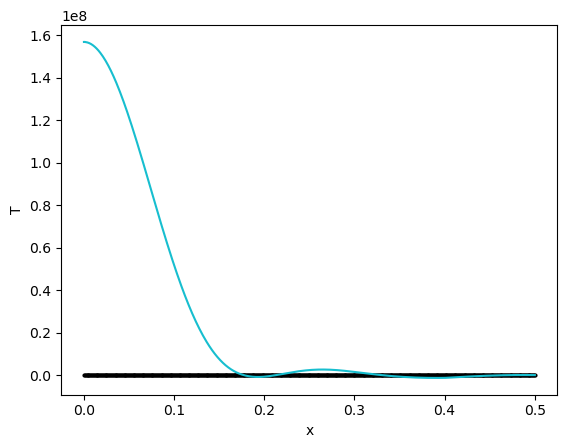

RMS_error is 3400534.9885441745 %


In [25]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)

fig, ax = plt.subplots()

plot1D(d_test.xi[0], sol_red, ax=ax)
plot1D(d_test.xi[0], NL_solution_p_fos_test, ax=ax, scattr=True, clr='k', sz=4)

plt.show()

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

In [26]:

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")



ROM Error without hyperreduction is 1.0229006395496624e-09 %



#### Speedups

In [27]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [28]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.8334506307646599
speedup with hyperreduction:27.101371887794894
